In [1]:
pip install arch yfinance statsmodels scipy yfinance tqdm openpyxl

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import yfinance as yf
import sqlite3

# === CONFIG ===
DB_PATH = "D:/Resume/Projects/JSW Energy/jswe_stock_data.db"
START_DATE = "2018-01-01"
END_DATE = "2025-08-11"  # or use pd.Timestamp.today().strftime("%Y-%m-%d")

# === Tickers & Table names ===
tickers = {
    "BZ=F": "brent_crude",        # Brent crude oil futures
    "^CNXENERGY": "nifty_energy", # Nifty Energy Index
    "INR=X": "usd_inr"            # USD/INR exchange rate
}

# === Connect to SQLite ===
conn = sqlite3.connect(DB_PATH)

for ticker, table in tickers.items():
    print(f"Fetching {ticker} ...")
    try:
        df = yf.download(ticker, start=START_DATE, end=END_DATE)
        if df.empty:
            print(f"❌ No data fetched for {ticker}, skipping.")
            continue

        # Keep only relevant columns
        df = df[["Close"]].reset_index()
        df.rename(columns={"Close": "close", "Date": "date"}, inplace=True)

        # Clean
        df["date"] = pd.to_datetime(df["date"])
        df.sort_values("date", inplace=True)
        df["close"].fillna(method="ffill", inplace=True)

        # Store in DB
        df.to_sql(table, conn, if_exists="replace", index=False)
        print(f"✅ Stored {ticker} in table '{table}' with {len(df)} rows.")

    except Exception as e:
        print(f"⚠ Error fetching {ticker}: {e}")

conn.close()
print("✅ All available data stored into SQLite database.")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching BZ=F ...
✅ Stored BZ=F in table 'brent_crude' with 1914 rows.
Fetching ^CNXENERGY ...



[*********************100%***********************]  1 of 1 completed

✅ Stored ^CNXENERGY in table 'nifty_energy' with 1862 rows.
Fetching INR=X ...
✅ Stored INR=X in table 'usd_inr' with 1981 rows.
✅ All available data stored into SQLite database.


In [40]:
import sqlite3
import pandas as pd

# 1. Connect to your database
db_path = "D:/Resume/Projects/JSW Energy/jswe_stock_data.db"  # <-- change this to your DB file path
conn = sqlite3.connect(db_path)

# 2. Function to clean column names and create new table
def clean_and_save_table(old_table, new_table):
    # Read the table
    df = pd.read_sql(f"SELECT * FROM {old_table}", conn)
    
    # Flatten tuple column names if they exist
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    
    # Rename to 'date' and 'close'
    df.rename(columns={df.columns[0]: "date", df.columns[1]: "close"}, inplace=True)
    
    # Save as new table
    df.to_sql(new_table, conn, if_exists="replace", index=False)
    print(f"✅ Table '{new_table}' created with columns: {df.columns.tolist()}")

# 3. Clean and create new tables
clean_and_save_table("usd_inr", "usd_inr_clean")
clean_and_save_table("nifty_energy", "nifty_energy_clean")

# 4. Close connection
conn.close()


✅ Table 'usd_inr_clean' created with columns: ['date', 'close']
✅ Table 'nifty_energy_clean' created with columns: ['date', 'close']


In [44]:
# Robust merging of cleaned tables from SQLite (handles tuple-like columns and messy names)
import sqlite3, pandas as pd
from functools import reduce
pd.set_option('display.max_columns', 200)

DB = "D:/Resume/Projects/JSW Energy/jswe_stock_data.db"
conn = sqlite3.connect(DB)

# 1) list tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)['name'].tolist()
print("Tables in DB:", tables)

def load_and_clean(table):
    df = pd.read_sql(f"SELECT * FROM \"{table}\"", conn)
    orig_cols = list(df.columns)
    # flatten tuple-like column names (e.g. ('date','') or ('close','BZ=F'))
    new_cols = []
    for c in orig_cols:
        if isinstance(c, tuple):
            # join non-empty parts with underscore, strip spaces
            parts = [str(p).strip() for p in c if p not in (None, "")]
            new_cols.append("_".join(parts).strip().lower() or str(c))
        else:
            new_cols.append(str(c).strip().lower())
    df.columns = new_cols

    # detect date-like column
    date_candidates = [c for c in df.columns if 'date' in c]
    if not date_candidates:
        raise KeyError(f"No date-like column found in table '{table}'. Columns: {df.columns.tolist()}")
    date_col = date_candidates[0]
    # normalize
    df = df.rename(columns={date_col: 'date'})

    # convert date to datetime
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    if df['date'].isna().all():
        raise ValueError(f"All dates failed to parse in table '{table}' — sample values: {df[date_col].unique()[:5]}")

    # detect a price-like column (prefer close / adj_close / price)
    price_candidates = [c for c in df.columns if c != 'date' and any(x in c for x in ('close','adj','price','last'))]
    if not price_candidates:
        # as fallback, pick first non-date column
        other_cols = [c for c in df.columns if c != 'date']
        if not other_cols:
            raise KeyError(f"No non-date columns found in table '{table}'.")
        price_col = other_cols[0]
    else:
        price_col = price_candidates[0]

    new_price_col = f"{table}_close"
    df = df.rename(columns={price_col: new_price_col})

    # keep only date + price col
    df = df[['date', new_price_col]]
    # sort and drop rows with null date or price
    df = df.sort_values('date').dropna(subset=['date', new_price_col]).reset_index(drop=True)
    print(f"Loaded '{table}': date_col='{date_col}' → 'date', price_col='{price_col}' → '{new_price_col}', rows={len(df)}")
    return df

# Load & clean all tables, but skip any tiny meta tables if present
cleaned = []
for t in tables:
    try:
        cleaned_df = load_and_clean(t)
        cleaned.append(cleaned_df)
    except Exception as e:
        print(f"Skipping table '{t}': {e}")

if not cleaned:
    raise SystemExit("No tables were loaded successfully. Fix the tables and try again.")

# Merge on date using inner join (only keep dates present in every table)
merged = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), cleaned)
merged = merged.sort_values('date').dropna().reset_index(drop=True)
print("\nMerged shape:", merged.shape)
print(merged.head())

# Save merged table back to DB
merged.to_sql("merged_exog_prices", conn, if_exists='replace', index=False)
print("Saved merged table to 'merged_exog_prices' in DB.")

conn.close()


Tables in DB: ['quarters', 'customization', 'data_sheet', 'income_statement_cleaned', 'balance_sheet_cleaned', 'cash_flow_cleaned', 'stock_prices', 'brent_crude', 'nifty_energy', 'usd_inr', 'usd_inr_clean', 'nifty_energy_clean']
Skipping table 'quarters': "No date-like column found in table 'quarters'. Columns: ['jsw energy ltd', 'unnamed: 1', 'unnamed: 2', 'unnamed: 3', 'unnamed: 4', 'unnamed: 5', 'unnamed: 6', 'unnamed: 7', 'unnamed: 8', 'screener.in', 'unnamed: 10']"
Skipping table 'customization': "No date-like column found in table 'customization'. Columns: ['how to use it?', 'unnamed: 1', 'unnamed: 2']"
Skipping table 'data_sheet': "No date-like column found in table 'data_sheet'. Columns: ['company name', 'jsw energy ltd', 'unnamed: 2', 'unnamed: 3', 'unnamed: 4', 'unnamed: 5', 'unnamed: 6', 'unnamed: 7', 'unnamed: 8', 'unnamed: 9', 'unnamed: 10']"
Skipping table 'income_statement_cleaned': "No date-like column found in table 'income_statement_cleaned'. Columns: ['line_item', '2

In [46]:
import sqlite3
import pandas as pd
import numpy as np

DB = "D:/Resume/Projects/JSW Energy/jswe_stock_data.db"
conn = sqlite3.connect(DB)

# Load merged table
merged = pd.read_sql("SELECT * FROM merged_exog_prices", conn, parse_dates=['date'])
conn.close()

# Set date index & sort
merged = merged.sort_values('date').set_index('date')

print("Columns:", merged.columns.tolist())
print(merged.head())

# Step 1 — Identify JSW column (target) & exogenous columns
target_col = [c for c in merged.columns if 'stock_prices_close' in c.lower()][0]  # e.g. 'jsw_energy_close'
exog_cols = [c for c in merged.columns if c != target_col]

# Step 2 — Compute daily % returns
returns_df = merged.pct_change().dropna()

y = returns_df[target_col]      # target series
X = returns_df[exog_cols]       # exogenous variables

print("\nTarget variable:", target_col)
print("Exogenous variables:", exog_cols)
print("\nSample returns data:")
print(returns_df.head())

# Save returns to DB (optional)
conn = sqlite3.connect(DB)
returns_df.to_sql("merged_exog_returns", conn, if_exists='replace', index=True)
conn.close()
print("\nSaved returns table as 'merged_exog_returns'.")


Columns: ['stock_prices_close', 'brent_crude_close', 'nifty_energy_close', 'usd_inr_close', 'usd_inr_clean_close', 'nifty_energy_clean_close']
            stock_prices_close  brent_crude_close  nifty_energy_close  \
date                                                                    
2020-01-03           66.593330          68.599998        16054.799805   
2020-01-06           63.605183          68.910004        15737.049805   
2020-01-07           66.498482          68.269997        15793.750000   
2020-01-08           67.541969          65.440002        15664.950195   
2020-01-09           65.834457          65.370003        15900.349609   

            usd_inr_close  usd_inr_clean_close  nifty_energy_clean_close  
date                                                                      
2020-01-03      71.415001            71.415001              16054.799805  
2020-01-06      71.731003            71.731003              15737.049805  
2020-01-07      71.787003            71.78700

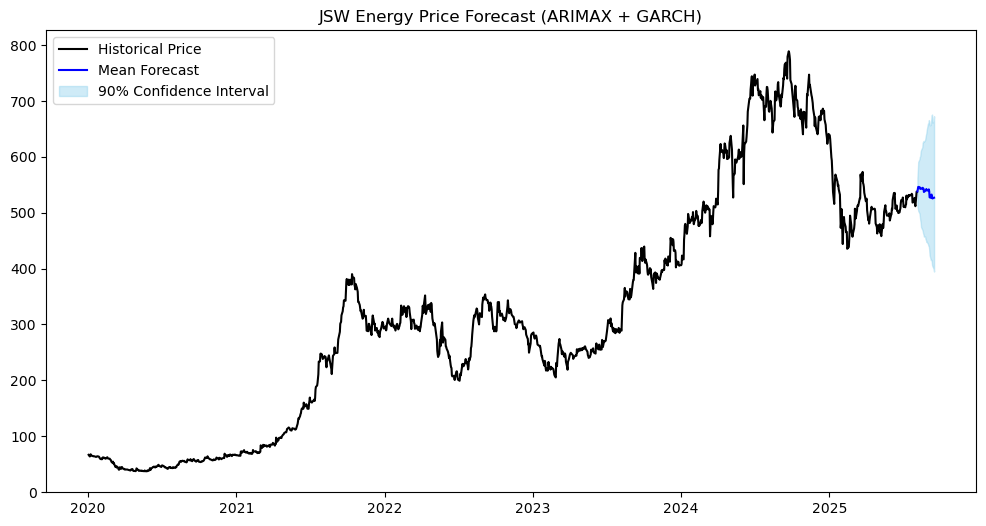

In [56]:
import sqlite3
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
import matplotlib.pyplot as plt

# -----------------------
# 1. Load from SQLite
# -----------------------
conn = sqlite3.connect("D:/Resume/Projects/JSW Energy/jswe_stock_data.db")

# Prices table
prices_df = pd.read_sql("SELECT * FROM merged_exog_prices", conn)

# Returns table
returns_df = pd.read_sql("SELECT * FROM merged_exog_returns", conn)

# Convert date to datetime
prices_df['date'] = pd.to_datetime(prices_df['date'])
returns_df['date'] = pd.to_datetime(returns_df['date'])

# Sort by date
prices_df = prices_df.sort_values('date').reset_index(drop=True)
returns_df = returns_df.sort_values('date').reset_index(drop=True)

# -----------------------
# 2. Prepare ARIMAX Inputs
# -----------------------
# Target: JSW Energy returns
ret = returns_df['stock_prices_close']

# Exogenous variables (drop date & JSW return column)
exog = returns_df.drop(columns=['date', 'stock_prices_close'])

# -----------------------
# 3. Fit ARIMAX on returns
# -----------------------
ARIMA_ORDER = (1, 0, 1)  # can be tuned
model_arimax = SARIMAX(ret, order=ARIMA_ORDER, exog=exog)
results_arimax = model_arimax.fit(disp=False)

# Mean forecast for next 30 days (reusing last 30 days of exog for demo)
future_exog = exog.iloc[-30:]
final_mu_fore = results_arimax.get_forecast(steps=30, exog=future_exog).predicted_mean

# -----------------------
# 4. Fit GARCH on ARIMAX residuals
# -----------------------
residuals = results_arimax.resid
garch = arch_model(residuals, vol='Garch', p=1, q=1, dist='t')
garch_fitted = garch.fit(disp="off")

final_sigma_fore = np.sqrt(
    garch_fitted.forecast(horizon=30).variance.values[-1]
)

# ✅ FIX: reset index to avoid KeyError during simulation loop
mu_forecast = pd.Series(final_mu_fore).reset_index(drop=True)
sigma_forecast = pd.Series(final_sigma_fore).reset_index(drop=True)

# -----------------------
# 5. Combine ARIMAX + GARCH for Price Simulation
# -----------------------
last_price = prices_df['stock_prices_close'].iloc[-1]
n_sims = 500
horizon = 30

sim_paths = np.zeros((horizon, n_sims))
for i in range(n_sims):
    prices = [last_price]
    for t in range(horizon):
        shock = np.random.normal(mu_forecast[t], sigma_forecast[t])
        prices.append(prices[-1] * (1 + shock))
    sim_paths[:, i] = prices[1:]

# -----------------------
# 6. Plot fan chart
# -----------------------
plt.figure(figsize=(12, 6))
plt.plot(prices_df['date'], prices_df['stock_prices_close'],
         label="Historical Price", color="black")
forecast_dates = pd.date_range(prices_df['date'].iloc[-1], periods=horizon+1, freq='B')[1:]
plt.plot(forecast_dates, sim_paths.mean(axis=1), color="blue", label="Mean Forecast")
plt.fill_between(forecast_dates,
                 np.percentile(sim_paths, 5, axis=1),
                 np.percentile(sim_paths, 95, axis=1),
                 color="skyblue", alpha=0.4, label="90% Confidence Interval")
plt.legend()
plt.title("JSW Energy Price Forecast (ARIMAX + GARCH)")
plt.show()


Starting rolling refit...


  6%|▌         | 64/1084 [00:31<08:42,  1.95it/s]C:\Users\Aditya Sakpal\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
  7%|▋         | 79/1084 [00:39<08:50,  1.89it/s]C:\Users\Aditya Sakpal\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 11%|█         | 121/1084 [00:58<08:50,  1.81it/s]C:\Users\Aditya Sakpal\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 18%|█▊        | 193/1084 [01:30<07:56,  1.87it/s]C:\Users\Aditya Sakpal\anaconda3\Lib\site-packages\arch\univariate\

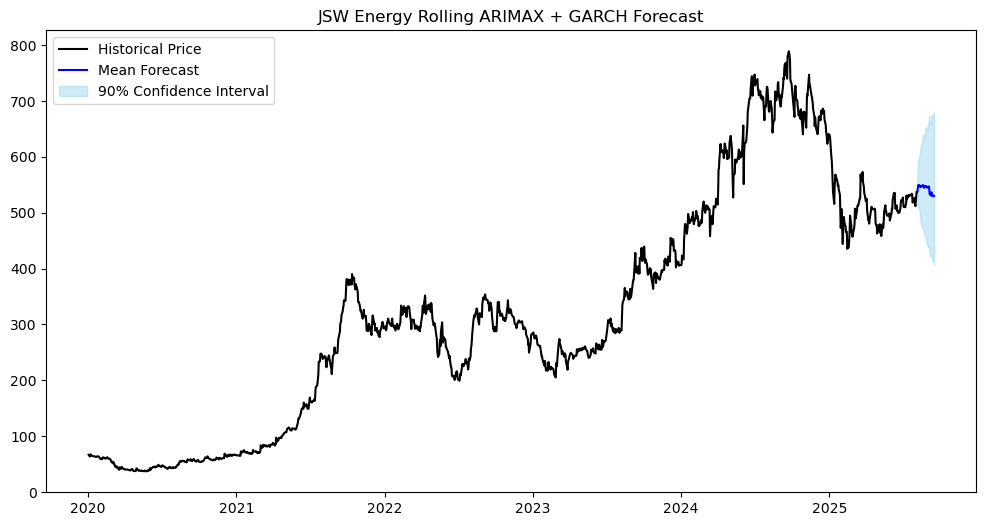

In [57]:
import sqlite3
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------
# 1. Load data from SQLite
# -----------------------
conn = sqlite3.connect("D:/Resume/Projects/JSW Energy/jswe_stock_data.db")
prices_df = pd.read_sql("SELECT * FROM merged_exog_prices", conn)
returns_df = pd.read_sql("SELECT * FROM merged_exog_returns", conn)
conn.close()

# Convert date columns
prices_df['date'] = pd.to_datetime(prices_df['date'])
returns_df['date'] = pd.to_datetime(returns_df['date'])

# Sort data
prices_df = prices_df.sort_values('date').reset_index(drop=True)
returns_df = returns_df.sort_values('date').reset_index(drop=True)

# Target and exogenous variables
ret = returns_df['stock_prices_close']
exog = returns_df.drop(columns=['date', 'stock_prices_close'])

# -----------------------
# 2. Rolling Refit Setup
# -----------------------
ARIMA_ORDER = (1, 0, 1)
INIT_TRAIN_DAYS = 250  # first window size
HORIZON = 30
N_SIMS = 500

mu_series = []
sigma_series = []

print("Starting rolling refit...")

for i in tqdm(range(INIT_TRAIN_DAYS, len(ret))):
    # Rolling train set
    train_ret = ret.iloc[i-INIT_TRAIN_DAYS:i]
    train_exog = exog.iloc[i-INIT_TRAIN_DAYS:i]
    
    # Fit ARIMAX
    model_arimax = SARIMAX(train_ret, order=ARIMA_ORDER, exog=train_exog)
    results_arimax = model_arimax.fit(disp=False)
    
    # One-step mean forecast
    mu_next = results_arimax.get_forecast(
        steps=1,
        exog=exog.iloc[[i]]
    ).predicted_mean.iloc[0]
    
    # Fit GARCH on residuals
    residuals = results_arimax.resid
    garch = arch_model(residuals, vol='Garch', p=1, q=1, dist='t')
    garch_fitted = garch.fit(disp="off")
    sigma_next = np.sqrt(garch_fitted.forecast(horizon=1).variance.values[-1][0])
    
    mu_series.append(mu_next)
    sigma_series.append(sigma_next)

# Align forecast series
mu_series = pd.Series(mu_series, index=returns_df['date'].iloc[INIT_TRAIN_DAYS:])
sigma_series = pd.Series(sigma_series, index=returns_df['date'].iloc[INIT_TRAIN_DAYS:])

# -----------------------
# 3. Final Fit for Forecast Simulation
# -----------------------
# Fit on full dataset
final_arimax = SARIMAX(ret, order=ARIMA_ORDER, exog=exog).fit(disp=False)
future_exog = exog.iloc[-HORIZON:]
mu_forecast = final_arimax.get_forecast(steps=HORIZON, exog=future_exog).predicted_mean.reset_index(drop=True)

residuals = final_arimax.resid
final_garch = arch_model(residuals, vol='Garch', p=1, q=1, dist='t').fit(disp="off")
sigma_forecast = np.sqrt(final_garch.forecast(horizon=HORIZON).variance.values[-1])
sigma_forecast = pd.Series(sigma_forecast).reset_index(drop=True)

# -----------------------
# 4. Monte Carlo Simulation
# -----------------------
last_price = prices_df['stock_prices_close'].iloc[-1]
sim_paths = np.zeros((HORIZON, N_SIMS))

for i in range(N_SIMS):
    prices = [last_price]
    for t in range(HORIZON):
        shock = np.random.normal(mu_forecast[t], sigma_forecast[t])
        prices.append(prices[-1] * (1 + shock))
    sim_paths[:, i] = prices[1:]

# -----------------------
# 5. Plot Fan Chart
# -----------------------
plt.figure(figsize=(12, 6))
plt.plot(prices_df['date'], prices_df['stock_prices_close'], label="Historical Price", color="black")

forecast_dates = pd.date_range(prices_df['date'].iloc[-1], periods=HORIZON+1, freq='B')[1:]
plt.plot(forecast_dates, sim_paths.mean(axis=1), color="blue", label="Mean Forecast")
plt.fill_between(forecast_dates,
                 np.percentile(sim_paths, 5, axis=1),
                 np.percentile(sim_paths, 95, axis=1),
                 color="skyblue", alpha=0.4, label="90% Confidence Interval")

plt.legend()
plt.title("JSW Energy Rolling ARIMAX + GARCH Forecast")
plt.show()


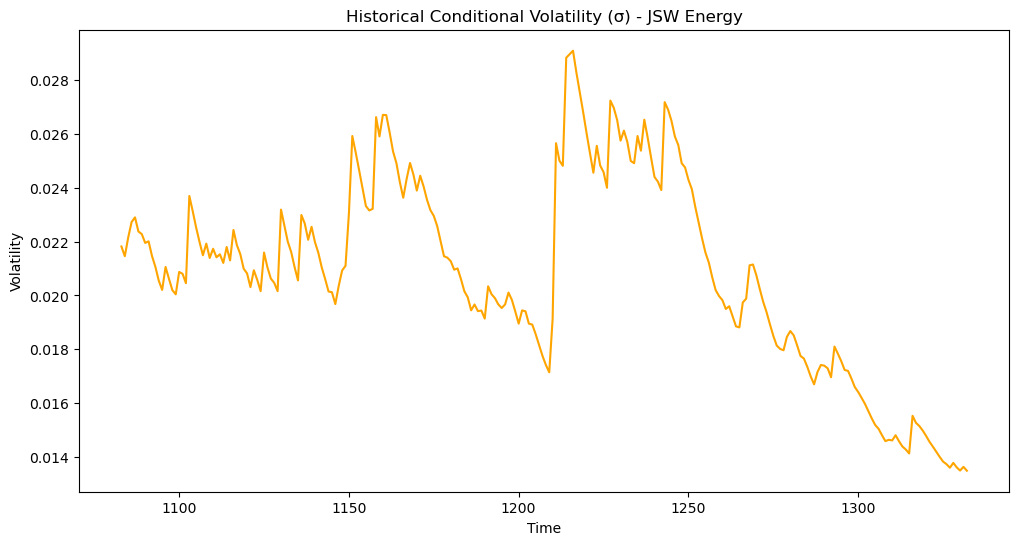

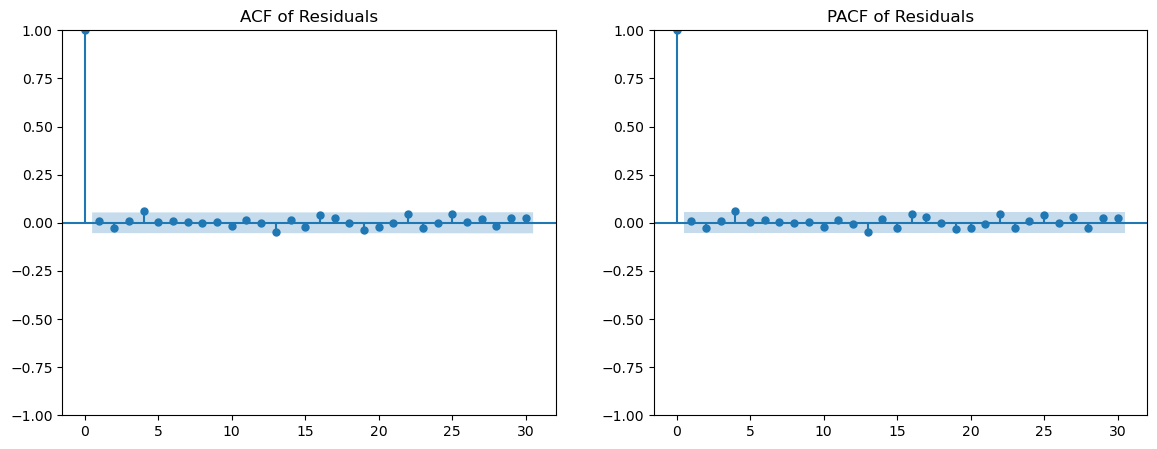

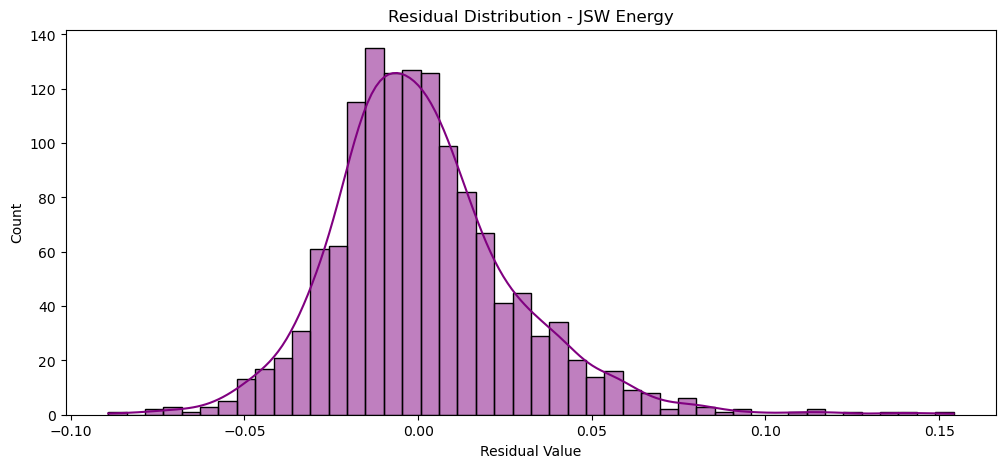

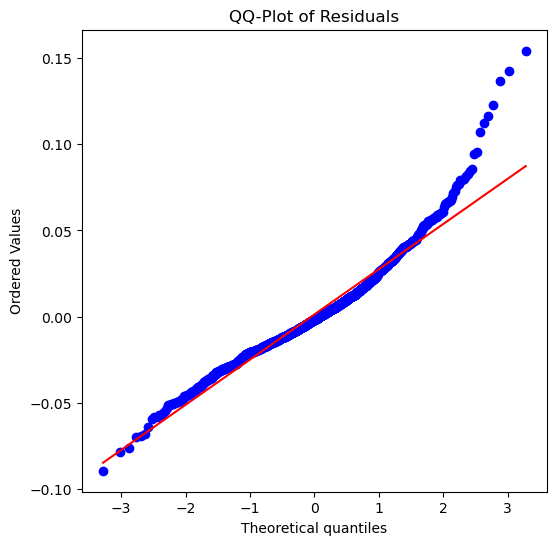

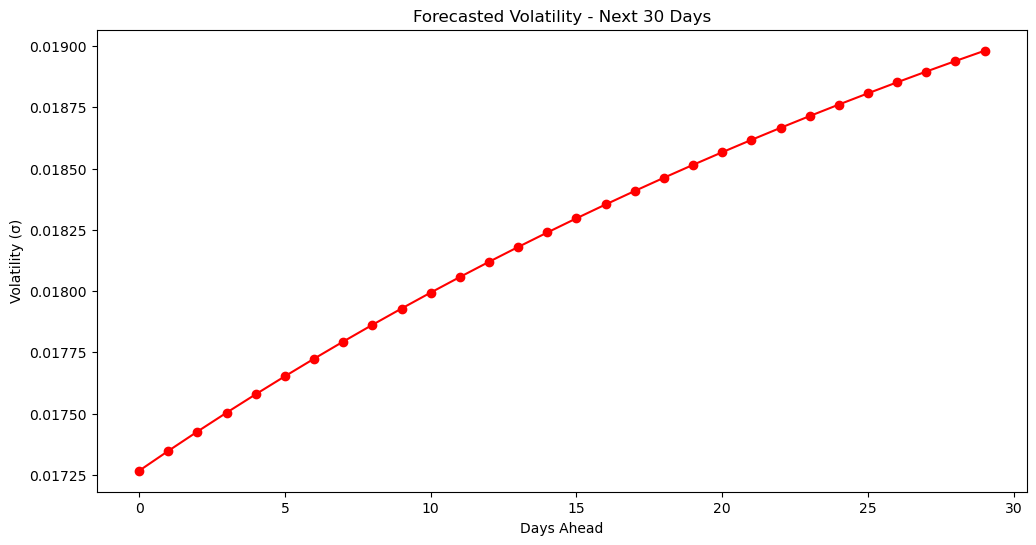

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats

# 1. Plot historical conditional volatility
plt.figure(figsize=(12,6))
plt.plot(garch_fitted.conditional_volatility, color='orange')
plt.title("Historical Conditional Volatility (σ) - JSW Energy")
plt.ylabel("Volatility")
plt.xlabel("Time")
plt.show()

# 2. ACF & PACF of residuals
fig, ax = plt.subplots(1, 2, figsize=(14,5))
plot_acf(residuals, ax=ax[0], lags=30)
plot_pacf(residuals, ax=ax[1], lags=30)
ax[0].set_title("ACF of Residuals")
ax[1].set_title("PACF of Residuals")
plt.show()

# 3. Residual distribution
plt.figure(figsize=(12,5))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residual Distribution - JSW Energy")
plt.xlabel("Residual Value")
plt.show()

# QQ-plot
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-Plot of Residuals")
plt.show()

# 4. Next 30-day volatility forecast
vol_forecast = garch_fitted.forecast(horizon=30).variance.values[-1]**0.5
plt.figure(figsize=(12,6))
plt.plot(vol_forecast, marker='o', color='red')
plt.title("Forecasted Volatility - Next 30 Days")
plt.ylabel("Volatility (σ)")
plt.xlabel("Days Ahead")
plt.show()
